# Espalhamento Compton

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sys

sys.path.insert(0, "../")

from scipy.optimize import curve_fit
from scipy.signal import gaussian
from scipy.ndimage import filters
from scipy.integrate import simps
from ggplot import *

from common import *

%matplotlib inline

/projects/anaconda3/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/projects/anaconda3/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/projects/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Neste experimento, observaremos o espalhamento compton de fótons gamma de várias fontes nos elétrons dentro do cristal de NaI(Tl) do cintilador.

O efeito Compton se manifesta nos espectros $\gamma$ como um excesso de medidas na região com energias inferiores a um fotopico. Esta região possui uma queda súbita, que ocorre na máxima energia possível depositada num elétron (i.e., a energia do elétron num espalhamento frontal). Esta queda é denominada _compton edge_.

Além disso, observa-se um pico de contagens na região anterior ao fotopico. Este pico é devido ao espalhamento Compton dos fótons $\gamma$ fora do detector, que, espalhados, reentram no cristal e depositam sua energia. A medida deste pico é portanto uma medida da energia dos fótons espalhados. Especificamente, os fótons que reentram no cristal são aqueles que espalharam (quase)frontalmente acima do cristal. A energia deste _pico de backscattering_, $E_{BS}$ é portanto complementar à energia do compton edge, $E_{CE}$ com relação à energia do fotopico, $E_\gamma$:

$$ E_{BS} + E_{CE} = E_\gamma $$

Da teoria do espalhamento compton, podemos ainda, medindo as energias $E_{CE}$ e $E_{BS}$, obter a massa do elétron. A massa obtida a partir das medições do compton edge, $m_{CE}$ é dada por

$$ m_{CE} c^2 = \frac{2E_\gamma^2}{E_{max}} - 2E_\gamma $$

E a massa obtida das medições do pico de backscattering, $m_{BE}$, por sua vez é

$$ m_{BS} c^2 = \frac{2E_\gamma^2}{E_\gamma - E_{BS}} - 2 E_\gamma $$

A energia do fotopico pode ser obtida a partir dos valores padrão.

Medimos, portanto, as energias do pico de backscattering e do compton edge para as linhas de $511$ keV do ${}^{22}$Na, de $835$ keV do ${}^{54}$Mn e de $661$ keV do ${}^{137}$Cs, e com estes valores e suas incertezas determinamos para cada uma destas medições a massa do elétron.

Procedemos da seguinte forma

* Para cada amostra, carregamos os dados e os calibramos
* Definimos uma região de observação contendo o fotopico e o pico de backscatter
* Suavizamos os dados (aplicando médias locais com pesos gaussianos) e calculamos a derivada numérica dos dados
* Encontramos o fotopico a partir do primeiro ponto onde a derivada deixa de ser positiva e se torna negativa.
* Obtivemos a incerteza do fotopico a partir da incerteza dos parâmetros da calibração. Esta é uma boa estimativa pois, como verificado durante a análise dos espectros de várias fontes comerciais, esta é a maior fonte de incerteza (sendo a incerteza obtida ao ajustar os picos tipicamente desprezível)
* Encontramos, analisando a derivada do sinal, o mínimo mais próximo do fotopico: esta é a energia do background do compton edge
* Encontramos a energia do platô do compton edge, encontrando o primeiro máximo da derivada à esquerda do mínimo compton determinado no passo anterior
* Seguindo joliette1994, encontramos o ponto onde a energia cai a 54 % da diferença de energia entre o platô e o background. Esta é a energia do compton edge
* Ainda seguindo joliette1994, estimamos a incerteza na energia do compton edge como a variação da energia do compton edge quando variamos a fração de 50% a 58% (joliette1994 argumenta, usando simulações de monte carlo, que este é o desvio padrão da fração utilizada).

Por fim, calculamos a média, ponderada pelo inverso do desvio ao quadrado, das diferentes massas obtidas, bem como o desvio associado. Calculamos também o $\chi^2$ normalizado pelo número de graus de liberdade desta medida, e também o desvio relativo ao valor padrão aceito pelo CODATA.

In [2]:
data_dir = "../../dados"
pars_calibracao = np.array([3.8215880409588541e-05, 0.031908378390707419, 6.140984458104163])
incertezas_calibracao = np.array([2.0005452742905427e-05, 0.013574765061956408, 2.0394318835612819])

arquivos = {
    'mn54': os.path.join(data_dir, 'mn54_15032017_1624.tsv'),
    'cs137': os.path.join(data_dir, 'cs137_15032017_1705.tsv'),
    'na22 - 511 keV': os.path.join(data_dir, 'na22_15032017_1622.tsv'),
}

# energias tabeladas para as amostras utilizadas
energias_padrao = {
    'mn54': 834.85,
    'cs137': 661.66,
    'na22 - 511 keV': 511,
}


 cs137
Energia pico backscatter: 211.5 +/- 1.8 keV
Energia Compton Edge: 481.7 +/- 3.3 keV
Energia fotopico: 661.66 keV
Edge + Backscatter: 693.2 +/- 10.7 keV
Massa Edge: 494.4 +/- 3.4 keV/c²
Massa Backscattering: 621.6 +/- 7.8 keV/c²

 mn54
Energia pico backscatter: 204.0 +/- 1.8 keV
Energia Compton Edge: 643.9 +/- 4.1 keV
Energia fotopico: 834.85 keV
Edge + Backscatter: 847.9 +/- 12.8 keV
Massa Edge: 495.3 +/- 3.1 keV/c²
Massa Backscattering: 539.9 +/- 6.3 keV/c²

 na22 - 511 keV
Energia pico backscatter: 201.5 +/- 1.8 keV
Energia Compton Edge: 345.7 +/- 3.5 keV
Energia fotopico: 511.00 keV
Edge + Backscatter: 547.2 +/- 10.4 keV
Massa Edge: 488.7 +/- 4.9 keV/c²
Massa Backscattering: 665.5 +/- 9.7 keV/c²


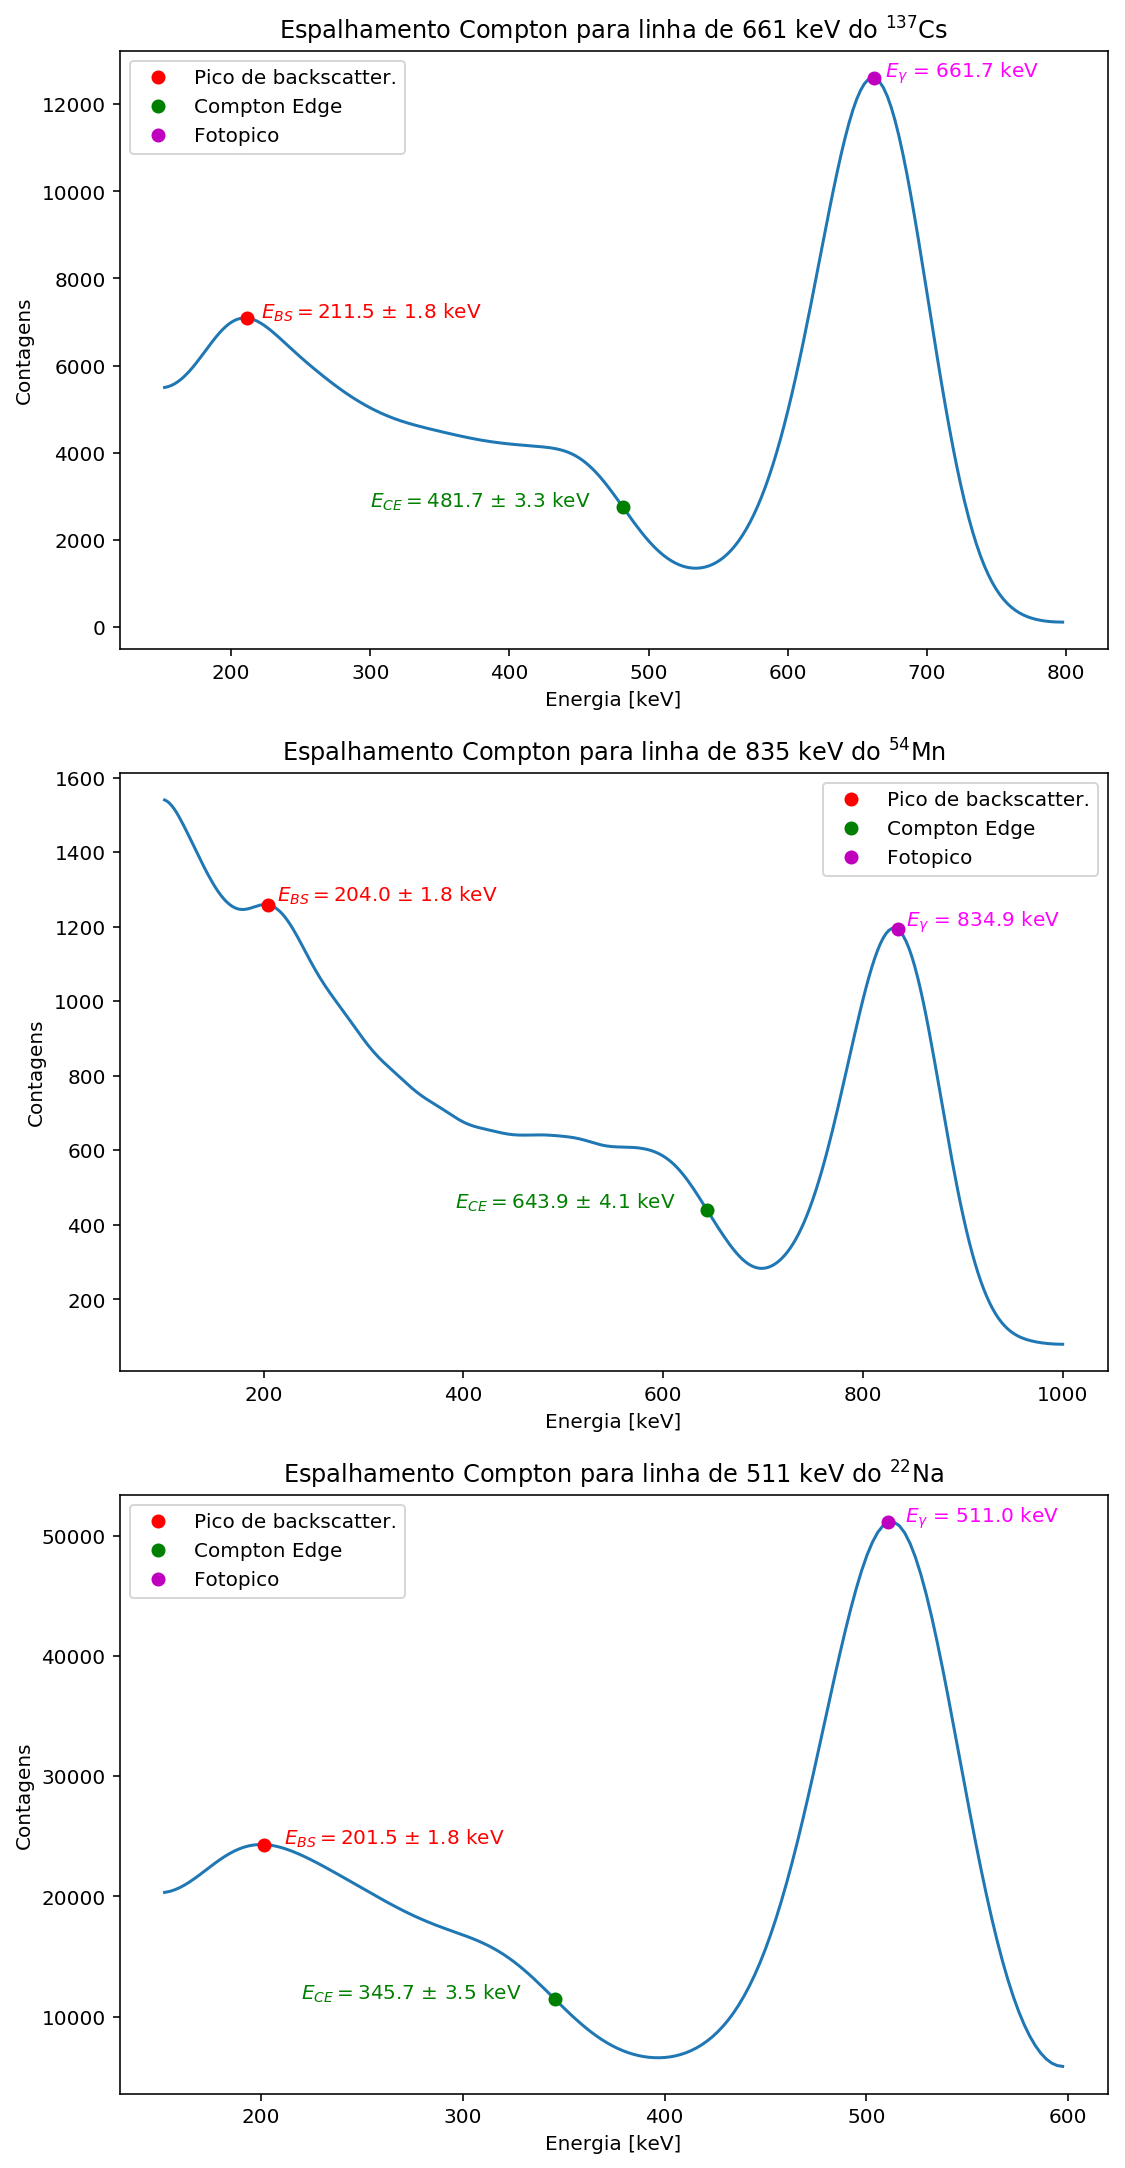

In [3]:
# define regiões de análise para cada amostra
min_energies = {
    'mn54': 100,
    'cs137': 150,
    'na22 - 511 keV': 150,
}
max_energies = {
    'mn54': 1000,
    'cs137': 800,
    'na22 - 511 keV': 600,
}
titulos = {
    'na22 - 511 keV': "Espalhamento Compton para linha de 511 keV do ${}^{22}$Na",
    'cs137': "Espalhamento Compton para linha de 661 keV do ${}^{137}$Cs",
    'mn54': "Espalhamento Compton para linha de 835 keV do ${}^{54}$Mn",
}

# dicionários para guardar resultados
massas_bs = {}
massas_edge = {}
incertezas_bs = {}
incertezas_edge = {}
Ts = {}
dTs = {}
incertezas_Ts = {}

fig = plt.figure(figsize=(8, 15))

for i, key in enumerate(arquivos):
    print('\n', key)
    
    # seleciona arquivo, carrega dados e calibra
    arquivo = arquivos[key]
    canais, contagens = load_data(arquivo)
    energias = calibracao(canais, pars_calibracao)

    # seleciona apenas região de baixas energias relevante - entre min_energies[key] e max_energies[key]
    max_energy = max_energies[key]
    min_energy = min_energies[key]
    mask = (energias < max_energy) & (energias > min_energy)
    contagens, energias, canais = contagens[mask], energias[mask], canais[mask]

    # suaviza contagens
    contagens_smooth = smooth(contagens, 6)
    
    # calcula derivada (numérica) de contagens
    derivada_contagens = np.gradient(contagens_smooth)
    
    # encontra pico de backscattering a partir da derivada
    # (picos são pontos onde o sinal da derivada vai de + a -)
    pico_bs = np.where(
        (np.roll(derivada_contagens, 1)[:-2] > 0) & 
        (derivada_contagens[:-2] <= 0)
    )[0][0]

    # seleciona parâmetros do pico de backscatter
    energia_bs, contagens_bs, contagens_smooth_bs, canal_bs = (
        energias[pico_bs], contagens[pico_bs], contagens_smooth[pico_bs], canais[pico_bs])
    
    # calcula incerteza no pico de backscatter devida à calibração
    incerteza_bs = np.sqrt(
        incertezas_calibracao[0] ** 2 * canal_bs ** 4 + 
        incertezas_calibracao[1] ** 2 * canal_bs ** 2 + 
        incertezas_calibracao[2])
    
    # carrega energia do fotopico a partir dos valores padrão
    energia_fp = energias_padrao[key]
    index = np.abs(energias - energia_fp).argmin()
    contagens_fp, contagens_smooth_fp = contagens[index], contagens_smooth[index]

    # calcula o mínimo compton
    y = derivada_contagens[energias < energia_fp]
    compton_min = np.where(
        (np.roll(y, 1)[:-2] < 0) & 
        (y[:-2] >= 0)
    )[0][-1]
    energia_compton_min, contagens_compton_min, contagens_smooth_compton_min = (
        energias[compton_min], contagens[compton_min], contagens_smooth[compton_min])
    
    # calcula o máximo compton
    # (primeiro máximo da derivada à esquerda do mínimo compton)
    z = y[:compton_min]
    compton_max = np.where(
        (np.roll(z, 1)[:-2] < z[:-2]) & 
        (z[:-2] > np.roll(z, -1)[:-2])
    )[0][-1]
    energia_compton_max, contagens_compton_max, contagens_smooth_compton_max = (
        energias[compton_max], contagens[compton_max], contagens_smooth[compton_max])
    
    # encontra energia do compton_edge
    contagens_compton_edge = 0.54 * (contagens_compton_max - contagens_compton_min) + contagens_compton_min
    edge_region = contagens[energias < energia_compton_min]
    compton_edge_index = np.where(
        (np.roll(edge_region, 1)[:-2] >= contagens_compton_edge) &
        (edge_region[:-2] <= contagens_compton_edge)
    )[-1][-1]
    energia_compton_edge, contagens_compton_edge, contagens_smooth_compton_edge, canal_ce = (
        energias[compton_edge_index], contagens[compton_edge_index], 
        contagens_smooth[compton_edge_index], canais[compton_edge_index])
    
    # calcula incerteza energia do compton edge
    # (usando que o desvio padrão da fração f correspondente ao compton edge é 0.04 - jolivette1994)
    delta = 0.04 * (contagens_compton_max - contagens_compton_min)
    edge_region = contagens[energias < energia_compton_min]
    index_min = np.where(
        (np.roll(edge_region, 1)[:-2] >= contagens_compton_edge - delta) &
        (edge_region[:-2] <= contagens_compton_edge - delta)
    )[-1][-1]
    index_max = np.where(
        (np.roll(edge_region, 1)[:-2] >= contagens_compton_edge + delta) &
        (edge_region[:-2] <= contagens_compton_edge + delta)
    )[-1][-1]
    delta_energia_compton_edge = np.abs(energias[index_max] - energias[index_min]) / 2
    
    # calcula incerteza da energia do compton edge devida à calibracao
    incerteza_ce = np.sqrt(
        incertezas_calibracao[0] ** 2 * canal_ce ** 4 + 
        incertezas_calibracao[1] ** 2 * canal_ce ** 2 + 
        incertezas_calibracao[2])
    
    # adiciona quadraticamente as incerteza na energia do compton edge
    # devidas à incerteza na fração f e na calibracao
    delta_energia_compton_edge = np.sqrt(delta_energia_compton_edge ** 2 + incerteza_ce ** 2)
    
    # Calcula massa do elétron
    m_edge = 2 * energia_fp ** 2 / energia_compton_edge - 2 * energia_fp
    m_bs = 2 * energia_fp ** 2 / (energia_fp - energia_bs) - 2 * energia_fp
    
    # Calcula incertezas
    dm_edge = delta_energia_compton_edge / energia_compton_edge * m_edge
    dm_bs = 2 * energia_fp ** 2 / (energia_fp - energia_bs) ** 2 * incerteza_bs
    
    # Guarda massas, energias cinéticas e incertezas
    massas_bs[key] = m_bs
    massas_edge[key] = m_edge
    incertezas_bs[key] = dm_bs
    incertezas_edge[key] = dm_edge
    Ts[key] = energia_compton_edge
    dTs[key] = delta_energia_compton_edge
    
    # Escreve resultados até então
    print("Energia pico backscatter: {:.1f} +/- {:.1f} keV".format(energia_bs, incerteza_bs))
    print("Energia Compton Edge: {:.1f} +/- {:.1f} keV".format(energia_compton_edge, delta_energia_compton_edge))
    print("Energia fotopico: {:.2f} keV".format(energia_fp))
    soma_ce_bs = energia_compton_edge + energia_bs
    delta_soma = (delta_energia_compton_edge / energia_compton_edge + incerteza_bs / energia_bs) * soma_ce_bs
    print("Edge + Backscatter: {:.1f} +/- {:.1f} keV".format(soma_ce_bs, delta_soma))
    print("Massa Edge: {:.1f} +/- {:.1f} keV/c²".format(m_edge, dm_edge))
    print("Massa Backscattering: {:.1f} +/- {:.1f} keV/c²".format(m_bs, dm_bs))

    # plota gráficos para conferência
    #fig = plt.figure(figsize=(12, 5))
    #ax = fig.add_subplot(121)
    #ax.set_title(key)
    #ax.plot(energias, contagens_smooth)
    #ax.plot(energia_bs, contagens_smooth_bs, 'ro')
    #ax.plot(energia_fp, contagens_smooth_fp, 'mo')
    #ax.plot(energia_compton_min, contagens_smooth_compton_min, 'go')
    #ax.plot(energia_compton_max, contagens_smooth_compton_max, 'bo')
    #ax.plot(energia_compton_edge, contagens_smooth_compton_edge, 'ro')
    #ax, old_ax = fig.add_subplot(122), ax
    #ax.plot(energias, derivada_contagens)
    #ax.plot(energia_bs, derivada_contagens[pico_bs], 'ro')
    #ax.plot(energia_compton_min, derivada_contagens[compton_min], 'go')
    #ax.plot(energia_compton_max, derivada_contagens[compton_max], 'bo')
    #ax.plot(energia_compton_edge, derivada_contagens[compton_edge_index], 'go')
    ax = fig.add_subplot(len(arquivos), 1, i+1)
    fig.tight_layout()
    ax.set_title(titulos[key])
    ax.set_xlabel("Energia [keV]")
    ax.set_ylabel("Contagens")
    ax.plot(energias, contagens_smooth)
    ax.plot(energia_bs, contagens_smooth_bs, 'ro', label="Pico de backscatter.")
    bs_label = "$E_{{BS}} = ${:.1f} $\pm$ {:.1f} keV".format(energia_bs, incerteza_bs)
    ax.text(energia_bs+10, contagens_smooth_bs+10, bs_label, color='red', fontsize=10)
    ax.plot(energia_compton_edge, contagens_smooth_compton_edge, 'go', label="Compton Edge")
    ce_label = "$E_{{CE}} = ${:.1f} $\pm$ {:.1f} keV".format(energia_compton_edge, delta_energia_compton_edge)
    ax.text(energia_compton_edge-int(0.28*(max_energy - min_energy)), 
            contagens_smooth_compton_edge+5, ce_label, color='green', fontsize=10)
    ax.plot(energia_fp, contagens_smooth_fp, 'mo', label="Fotopico")
    fp_label = "$E_\gamma$ = {:.1f} keV".format(energia_fp)
    ax.text(energia_fp+8, contagens_smooth_fp+8, fp_label, color='magenta', fontsize=10)
    ax.legend()
fig.savefig("plots_compton.pdf")

In [4]:
# agrupa todos os valores medidos para massas e suas incertezas
massas = list(massas_edge.values()) + list(massas_bs.values())
incertezas = list(incertezas_edge.values()) + list(incertezas_bs.values())
massas = np.array(massas)
incertezas = np.array(incertezas)

# computa media ponderada das massas, e incerteza associada
massa_eletron, soma_pesos = np.average(massas, weights = 1/incertezas ** 2, returned=True)
incerteza_massa_eletron = 1 / np.sqrt(soma_pesos)

massa_padrao_eletron = 510.9989461  # valor recomendado CODATA (keV)
incerteza_massa_padrao_eletron = 0.0000031

# calcula xi^2/dof
norm_chi_sq = np.sum(((massa_eletron - massas) / incertezas) ** 2) / (len(massas) - 1)

# calcula desvio
desvio = np.abs(massa_eletron - massa_padrao_eletron) / incerteza_massa_eletron

print("Massa final do elétron: {:.1f} +/- {:.1f} keV".format(massa_eletron, incerteza_massa_eletron))
print("Chi quadrado reduzido: {:.2f}".format(norm_chi_sq))
print("Massa padrão do elétron (CODATA): {:.7f} +/- {:.7f} keV".format(
    massa_padrao_eletron, incerteza_massa_padrao_eletron))
print("Desvio: {:.2f} desvios padrões".format(desvio))

Massa final do elétron: 511.7 +/- 1.9 keV
Chi quadrado reduzido: 108.54
Massa padrão do elétron (CODATA): 510.9989461 +/- 0.0000031 keV
Desvio: 0.35 desvios padrões


O desvio obtido é bastante baixo, sendo a medida compatível com o valor padrão. O valor de $\chi^2$ é porém inaceitavelmente grande. Provavelmente existe algum desvio sistemático não considerado, ou as incertezas estatísticas estão sendo subestimadas.

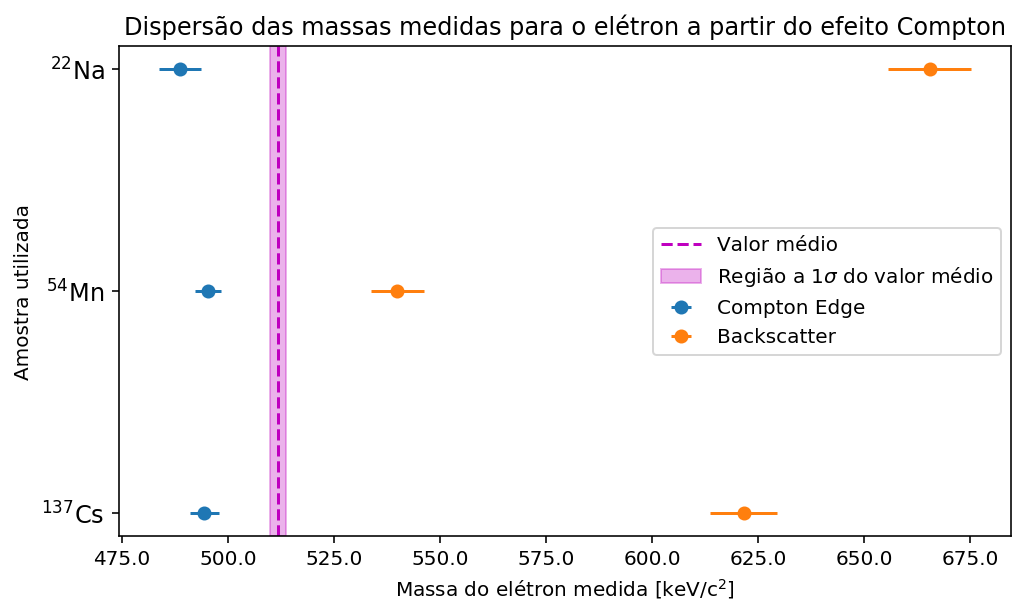

In [5]:
# plota dispersão das medidas de massa

fig = plt.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)
ax.errorbar(list(massas_edge.values()), range(len(massas_edge)), xerr=list(incertezas_edge.values()), 
            fmt='o', label="Compton Edge")
ax.errorbar(list(massas_bs.values()), range(len(massas_edge)), xerr=list(incertezas_bs.values()), 
            fmt='o', label="Backscatter")
ax.axvline(x=massa_eletron, ls='--', color='m', label='Valor médio')
ax.axvspan(massa_eletron - incerteza_massa_eletron, massa_eletron + incerteza_massa_eletron, alpha=0.3, color='m',
          label="Região a 1$\sigma$ do valor médio")

labels = {
    'mn54': '${}^{54}$Mn', 
    'cs137': '${}^{137}$Cs', 
    'na22 - 511 keV':'${}^{22}$Na',
}
ax.set_yticks(range(len(massas_edge)))
ax.set_yticklabels([labels[key] for key in massas_edge], fontsize=12)
ax.set_xticklabels(ax.get_xticks(), fontsize=10)
ax.set_xlabel("Massa do elétron medida [keV/c$^2$]", fontsize=10)
ax.set_ylabel("Amostra utilizada", fontsize=10)
ax.set_title("Dispersão das massas medidas para o elétron a partir do efeito Compton")
ax.legend(loc='center right')
fig.savefig('dispersao_massas.pdf')

Claramente há algum erro sistemático, superestimando a massa do elétron para medidas por backscattering e subestimando-as para medidas via compton edge.